In [0]:
!rm -r BEGAN_KERAS
!rm config.py
!git clone https://github.com/siddharthalodha/BEGAN_KERAS.git
!cp BEGAN_KERAS/config.py .

In [0]:
import os
os.makedirs('./resource')
os.makedirs('./generated')
#os.makedirs('/content/../../resource/')

# BEGAN major improvements
1. Auto-encoder as a discriminator - Took from EBGAN paper
2. Using wasserstein distance for loss function : Try to optimize lower bound of the Wasserstein distance
between auto-encoder loss distributions, not between sample distributions
3. 

In [0]:

#Code to download CelebA hdf5 dataset from google drive
!pip install PyDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileId = drive.CreateFile({'id': '1cUBPxqU-9Y6f_OAfPwdRmPg7ruZ2sfdk'})
print(fileId['title'])  # CelebA Dataset
fileId.GetContentFile('CelebA_64_data.h5')  # Save Drive file as a local file

In [16]:
#Import
%matplotlib inline
import matplotlib
import os
import pickle
from datetime import datetime

import keras.backend as K
import numpy as np
from keras.engine.topology import Container
from keras.optimizers import Adam

from config import BEGANConfig
from PIL import Image

#from generate_image import generate
#from began.models import build_model, load_model_weight

from keras import backend as K
from keras.engine import Input, Model
from keras.engine.topology import Container, Layer
from keras.layers import Lambda, Concatenate, Flatten, Dense, Reshape, Convolution2D, UpSampling2D
import h5py
from keras.callbacks import TensorBoard

In [16]:
#config = BEGANConfig()
#print(config.autoencoder_weight_filename)
#!cat config.py

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc

#Training
ESC = chr(0x1b)
UP = ESC+"[1A"

def training(config: BEGANConfig, epochs=3):
# loading dataset, and let values to 0.0 ~ 1.0
#    with open(config.dataset_filename, 'rb') as f:
#        dataset = pickle.load(f)  # type: np.ndarray
#        dataset = dataset / 255.0
#        info(dataset.shape)

    with h5py.File("./CelebA_64_data.h5", "r") as hf:
        dataset = hf["data"][:10000].astype(np.float32)
        dataset = dataset/255.0
        info(dataset.shape)
        dataset = dataset.transpose(0, 2, 3, 1)
        info(dataset.shape)

    batch_size = config.batch_size

    # building model and loading weight(if exists)
    autoencoder, generator, discriminator = build_model(config)
    load_model_weight(autoencoder, config.autoencoder_weight_filename)
    load_model_weight(generator, config.generator_weight_filename)
    load_model_weight(discriminator, config.discriminator_weight_filename)

    loss_d = DiscriminatorLoss(config.initial_k)  # special? loss object for BEGAN
    discriminator.compile(optimizer=Adam(), loss=loss_d)
    generator.compile(optimizer=Adam(), loss=create_generator_loss(autoencoder))
    lr_decay_step = 0
    last_m_global = np.Inf
    log_recorder = LogRecorder(config.training_log)

    # print("Generator Update Variables")
    # print_model_updates(generator)
    #
    # print("Discriminator Update Variables")
    # print_model_updates(discriminator)

    for ep in range(1, epochs+1):
        np.random.seed(ep * 100)
        # generate Z layer values for discriminator and generator
        zd = np.random.uniform(-1, 1, (len(dataset), config.hidden_size))
        zg = np.random.uniform(-1, 1, (len(dataset), config.hidden_size))

        # shuffle dataset index
        index_order = np.arange(len(dataset))
        np.random.shuffle(index_order)

        # set Learning Rate aling with decay rate and decay step
        lr = max(config.initial_lr * (config.lr_decay_rate ** lr_decay_step), config.min_lr)
        K.set_value(generator.optimizer.lr, lr)
        K.set_value(discriminator.optimizer.lr, lr)
        m_global_history = []
        info("LearningRate=%.7f" % lr)
        batch_len = len(dataset)//batch_size

        for b_idx in range(batch_len):
            index_list = index_order[b_idx*batch_size:(b_idx+1)*batch_size]

            # training discriminator
            in_x1 = dataset[index_list]  # (bs, row, col, ch)
            in_x2 = generator.predict_on_batch(zd[index_list])
            in_x = np.concatenate([in_x1, in_x2], axis=-1)  # (bs, row, col, ch*2)
            loss_discriminator = discriminator.train_on_batch(in_x, in_x)

            # training generator
            in_x1 = zg[index_list]
            loss_generator = generator.train_on_batch(in_x1, np.zeros_like(in_x2))  # y_true is meaningless

            # record M-Global
            m_global_history.append(loss_d.m_global)
            if b_idx > 0:
                print(UP + UP)
            log_info = dict(
                epoch=ep,
                batch_index=b_idx,
                batch_len=batch_len,
                m_global=loss_d.m_global,
                loss_discriminator=loss_discriminator,
                loss_generator=loss_generator,
                loss_real_x=loss_d.loss_real_x,
                loss_gen_x=loss_d.loss_gen_x,
                k=loss_d.k,
                lr=lr,
            )
            log_recorder.write(**log_info)
            
            info("ep=%(epoch)s, b_idx=%(batch_index)s/%(batch_len)s, MGlobal=%(m_global).5f, "
                 "Loss(D)=%(loss_discriminator).5f, Loss(G)=%(loss_generator).5f, Loss(X)=%(loss_real_x).5f, "
                 "Loss(G(Zd))=%(loss_gen_x).5f, K=%(k).6f" % log_info)
        


        m_global = np.average(m_global_history)
        if last_m_global <= m_global:  # decay LearningRate
            lr_decay_step += 1
        last_m_global = m_global

        # Save Model Weight in each epoch
        autoencoder.save_weights(config.autoencoder_weight_filename)
        generator.save_weights(config.generator_weight_filename)
        discriminator.save_weights(config.discriminator_weight_filename)

        # Generate Image in each epoch
        generate(config, "ep%03d" % ep, generator)

def create_generator_loss(autoencoder: Container):
    def generator_loss(y_true, y_pred):
        y_pred_dash = autoencoder(y_pred)
        return K.mean(K.abs(y_pred - y_pred_dash), axis=[1, 2, 3])
    return generator_loss


class DiscriminatorLoss:
    __name__ = 'discriminator_loss'

    def __init__(self, initial_k=0, lambda_k=0.001, gamma=0.5):
        self.lambda_k = lambda_k
        self.gamma = gamma
        self.k_var = K.variable(initial_k, dtype=K.floatx(), name="discriminator_k")
        self.m_global_var = K.variable(0, dtype=K.floatx(), name="m_global")
        self.loss_real_x_var = K.variable(0, name="loss_real_x")  # for observation
        self.loss_gen_x_var = K.variable(0, name="loss_gen_x")    # for observation
        self.updates = []

    def __call__(self, y_true, y_pred):  # y_true, y_pred shape: (BS, row, col, ch * 2)
        data_true, generator_true = y_true[:, :, :, 0:3], y_true[:, :, :, 3:6]
        data_pred, generator_pred = y_pred[:, :, :, 0:3], y_pred[:, :, :, 3:6]
        loss_data = K.mean(K.abs(data_true - data_pred), axis=[1, 2, 3])
        loss_generator = K.mean(K.abs(generator_true - generator_pred), axis=[1, 2, 3])
        ret = loss_data - self.k_var * loss_generator

        # for updating values in each epoch, use `updates` mechanism
        # DiscriminatorModel collects Loss Function's updates attributes
        mean_loss_data = K.mean(loss_data)
        mean_loss_gen = K.mean(loss_generator)

        # update K
        new_k = self.k_var + self.lambda_k * (self.gamma * mean_loss_data - mean_loss_gen)
        new_k = K.clip(new_k, 0, 1)
        self.updates.append(K.update(self.k_var, new_k))

        # calculate M-Global
        m_global = mean_loss_data + K.abs(self.gamma * mean_loss_data - mean_loss_gen)
        self.updates.append(K.update(self.m_global_var, m_global))

        # let loss_real_x mean_loss_data
        self.updates.append(K.update(self.loss_real_x_var, mean_loss_data))

        # let loss_gen_x mean_loss_gen
        self.updates.append(K.update(self.loss_gen_x_var, mean_loss_gen))

        return ret

    @property
    def k(self):
        return K.get_value(self.k_var)

    @property
    def m_global(self):
        return K.get_value(self.m_global_var)

    @property
    def loss_real_x(self):
        return K.get_value(self.loss_real_x_var)

    @property
    def loss_gen_x(self):
        return K.get_value(self.loss_gen_x_var)


def info(msg):
    now = datetime.now()
    print("%s: %s" % (now, msg))


class LogRecorder:
    def __init__(self, log_filename):
        if not os.path.exists(os.path.dirname(log_filename)):
            os.makedirs((os.path.dirname(log_filename)))
        self.file_out = open(log_filename, "wt")
        self.columns = None

    def write(self, **kwargs):
        if not self.columns:
            self.columns = list(sorted(kwargs.keys()))
            self.file_out.write(",".join(self.columns) + "\n")
        values = [str(kwargs.get(x, "")) for x in self.columns]
        self.file_out.write(",".join(values) + "\n")
        self.file_out.flush()


def print_model_updates(model):
    training_updates = model.optimizer.get_updates(
        model._collected_trainable_weights,
        model.constraints,
        model.total_loss)
    updates = model.updates + training_updates
    print("\n".join(sorted([str(x[0]) for x in updates])))

In [18]:
#Generate image
def generate(config: BEGANConfig, dir_name, generator=None):
    output_dir = "%s/%s" % (config.generated_dir, dir_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if generator is None:
        generator = build_generator(config)
        load_model_weight(generator, config.generator_weight_filename)

    np.random.seed(999)
    num_image = 20
    z = np.random.uniform(-1, 1, config.hidden_size * num_image).reshape((num_image, config.hidden_size))
    x = generator.predict(z)
    images = np.clip(x * 255, 0, 255).astype("uint8")
    print((x.shape, np.min(x), np.max(x)))

    for i in range(num_image):
        image_x = images[i]
        img = Image.fromarray(image_x)
        img.save("%s/gen_%03d.jpg" % (output_dir, i))
        img=mpimg.imread("%s/gen_%03d.jpg" % (output_dir, i))
        w=10
        h=10
        fig=plt.figure(figsize=(8, 8))
        columns = 4
        rows = 5
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()

In [19]:
#Main
def build_model(config: BEGANConfig):
    K.set_image_data_format('channels_last')

    autoencoder = build_autoencoder(config)
    generator = build_generator(config)
    discriminator = build_discriminator(config, autoencoder)

    return autoencoder, generator, discriminator


def load_model_weight(model: Container, weight_file):
    if os.path.exists(weight_file):
        print("loading model weight: %s" % weight_file)
        model.load_weights(weight_file)


def build_autoencoder(config: BEGANConfig, name="autoencoder"):
    encoder = build_encoder(config, name="%s/encoder" % name)
    decoder = build_decoder(config, name="%s/decoder" % name)
    autoencoder = Container(encoder.inputs, decoder(encoder.outputs), name=name)
    return autoencoder


def build_generator(config: BEGANConfig):
    decoder = build_decoder(config, name="generator_decoder")
    generator = Model(decoder.inputs, decoder.outputs, name="generator")
    return generator


def build_encoder(config: BEGANConfig, name="encoder"):
    n_filters = config.n_filters
    hidden_size = config.hidden_size
    n_layer = config.n_layer_in_conv

    dx = image_input = Input((config.image_height, config.image_width, 3))

    # output: (N, 32, 32, n_filters)
    dx = convolution_image_for_encoding(dx, n_filters, strides=(2, 2), name="%s/L1" % name, n_layer=n_layer)

    # output: (N, 16, 16, n_filters*2)
    dx = convolution_image_for_encoding(dx, n_filters * 2, strides=(2, 2), name="%s/L2" % name, n_layer=n_layer)

    # output: (N, 8, 8, n_filters*3)
    dx = convolution_image_for_encoding(dx, n_filters * 3, strides=(2, 2), name="%s/L3" % name, n_layer=n_layer)

    # output: (N, 8, 8, n_filters*4)
    dx = convolution_image_for_encoding(dx, n_filters * 4, strides=(1, 1), name="%s/L4" % name, n_layer=n_layer)

    dx = Flatten()(dx)
    hidden = Dense(hidden_size, activation='linear', name="%s/Dense" % name)(dx)

    encoder = Container(image_input, hidden, name=name)
    return encoder


def build_decoder(config: BEGANConfig, name):
    """
    generator and decoder( of discriminator) have same network structure, but don't share weights.
    This function takes different input layer, flow another network, and return different output layer.
    """
    n_filters = config.n_filters
    n_layer = config.n_layer_in_conv

    dx = input_z = Input((64, ))
    dx = Dense((8*8*n_filters), activation='linear', name="%s/Dense" % name)(dx)
    dx = Reshape((8, 8, n_filters))(dx)

    # output: (N, 16, 16, n_filters)
    dx = convolution_image_for_decoding(dx, n_filters, upsample=True, name="%s/L1" % name, n_layer=n_layer)

    # output: (N, 32, 32, n_filters)
    dx = convolution_image_for_decoding(dx, n_filters, upsample=True, name="%s/L2" % name, n_layer=n_layer)

    # output: (N, 64, 64, n_filters)
    dx = convolution_image_for_decoding(dx, n_filters, upsample=True, name="%s/L3" % name, n_layer=n_layer)

    # output: (N, 64, 64, n_filters)
    dx = convolution_image_for_decoding(dx, n_filters, upsample=False, name="%s/L4" % name, n_layer=n_layer)

    # output: (N, 64, 64, 3)
    image_output = Convolution2D(3, (3, 3), padding="same", activation="linear", name="%s/FinalConv" % name)(dx)
    decoder = Container(input_z, image_output, name=name)
    return decoder


def build_discriminator(config: BEGANConfig, autoencoder: Container):
    """
    
    Keras Model class is able to have several inputs/outputs. 
    But, loss functions should be defined each other, and the loss function cannot reference other inputs/outputs.
    For computing loss, two inputs/outputs are concatenated.
    """
    # IN Shape: [ImageHeight, ImageWidth, (real data(3 channels) + generated data(3 channels))]
    in_out_shape = (config.image_height, config.image_width, 3 * 2)
    all_input = Input(in_out_shape)

    # Split Input Data
    data_input = Lambda(lambda x: x[:, :, :, 0:3], output_shape=(config.image_height, config.image_width, 3))(all_input)
    generator_input = Lambda(lambda x: x[:, :, :, 3:6], output_shape=(config.image_height, config.image_width, 3))(all_input)

    # use same autoencoder(weights are shared)
    data_output = autoencoder(data_input)  # (bs, row, col, ch)
    generator_output = autoencoder(generator_input)

    # concatenate output to be same shape of input
    all_output = Concatenate(axis=-1)([data_output, generator_output])

    discriminator = DiscriminatorModel(all_input, all_output, name="discriminator")
    return discriminator


def convolution_image_for_encoding(x, filters, strides=(1, 1), name=None, n_layer=2):
    for i in range(1, n_layer):
        x = Convolution2D(filters, (3, 3), activation="elu", padding="same", name="%s/Conv%d" % (name, i))(x)

    x = Convolution2D(filters, (3, 3), activation="elu", padding="same", strides=strides,
                      name="%s/Conv%d" % (name, n_layer))(x)
    return x


def convolution_image_for_decoding(x, filters, upsample=None, name=None, n_layer=2):
    for i in range(1, n_layer+1):
        x = Convolution2D(filters, (3, 3), activation="elu", padding="same", name="%s/Conv%d" % (name, i))(x)
    if upsample:
        x = UpSampling2D()(x)
    return x


class DiscriminatorModel(Model):
    """Model which collects updates from loss_func.updates"""

    @property
    def updates(self):
        updates = super().updates
        if hasattr(self, 'loss_functions'):
            for loss_func in self.loss_functions:
                if hasattr(loss_func, 'updates'):
                    updates += loss_func.updates
        return updates

In [0]:
config = BEGANConfig()
training(config, epochs=500)

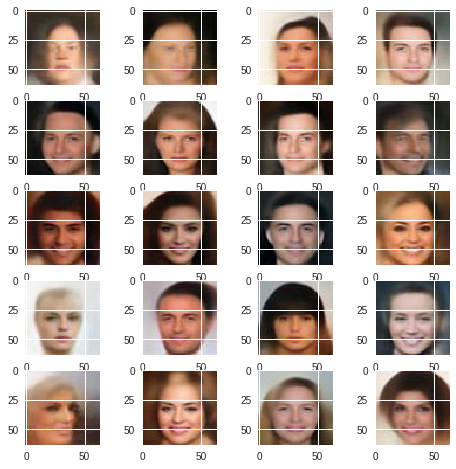

In [36]:
#Show final generated images (Ran till 85 epochs)

%matplotlib inline
import matplotlib
from PIL import Image

output_dir="generated/ep085"
fig=plt.figure(figsize=(8, 8))
for i in range(20):
        img=mpimg.imread("%s/gen_%03d.jpg" % (output_dir, i))
        w=10
        h=10
        columns = 4
        rows = 5
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
plt.show()